# Class attention applied to a text classification task

## FROZEN, DO NOT MODIFY



Same as `04_random_model_different_possible_classes.ipynb`, but implements a text classification model

In [1]:
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import class_attention as cat

%load_ext autoreload
%autoreload 2

In [2]:
def detorch(x):
    return x.detach().cpu().numpy()

In [3]:
train_texts = ["This is a news article", "Good news, everyone!", "It is cloudy with a chance of meatballs", "This is a sport article"]
train_labels = ["News", "News", "Weather", "Sport"]

In [4]:
class ClassAttentionModel(nn.Module):
    def __init__(self, text_vocab_size, n_classes, hidden_size):
        super().__init__()

        self.x_enc = nn.Sequential(nn.EmbeddingBag(text_vocab_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Sequential(nn.EmbeddingBag(n_classes, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

    def forward(self, x, c):
        h_x = self.x_enc(x)
        h_c = self.c_enc(c)

        logits = h_x @ h_c.T # + bias  # or make a residual connection with class network

        return logits


# Text encoder

In [5]:
text_tokenizer = cat.utils.make_whitespace_tokenizer(train_texts)
text_tokenizer.encode(train_texts[0]).ids

[4, 2, 3, 5, 6]

# Label encoder

Just use a tokenizer without UNK

In [6]:
label_tokenizer = cat.utils.make_whitespace_tokenizer(train_labels, unk_token=None)
label_tokenizer.encode(train_labels[0]).ids

[1]

# Dataset

In [7]:
dataset = cat.CatDataset(train_texts, text_tokenizer, train_labels, label_tokenizer)

dataset[0]

Preprocessing Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

(tensor([4, 2, 3, 5, 6]), tensor([1]))

# Collator

Collator also makes targets

In [16]:
from pprint import pprint

collator = cat.CatCollator(pad_token_id=0)
text_batch, unique_labels, targets = collator([dataset[0], dataset[2]])

print('Text:')
pprint(text_batch)

print('\nUnique labels:')
pprint(unique_labels)

print('Targets:')
pprint(targets)

Text:
tensor([[ 4,  2,  3,  5,  6,  0,  0,  0],
        [11,  2, 12, 13,  3, 14, 15, 16]])

Unique labels:
tensor([[1],
        [2]])
Targets:
tensor([0, 1])


# Dataloader

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collator)

In [18]:
next(iter(dataloader))

(tensor([[ 4,  2,  3,  5,  6],
         [ 7,  5,  8,  9, 10]]),
 tensor([[1]]),
 tensor([0, 0]))

## Train class attention

In [11]:
text_vocab_size = text_tokenizer.get_vocab_size()
n_unique_classes = label_tokenizer.get_vocab_size()

model = ClassAttentionModel(text_vocab_size, n_classes=n_unique_classes, hidden_size=32)
optimizer = torch.optim.Adam(model.parameters())

In [14]:
item = dataset[0]

x = item[0].unsqueeze(0)
c = item[1].unsqueeze(0)

model(x=x, c=c)

tensor([[-0.1149]], grad_fn=<MmBackward>)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Accuracy')

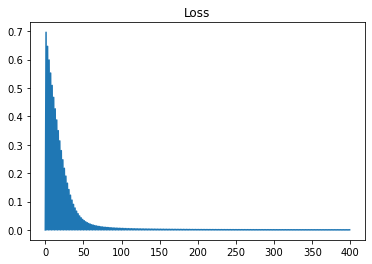

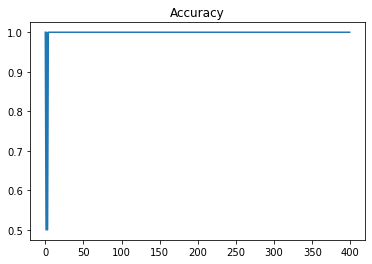

In [19]:
loss_hist = []
acc_hist = []

for _ in tqdm(range(200)):
    for x, c, y in dataloader:
        optimizer.zero_grad()

        logits = model(x, c)

        loss = F.cross_entropy(logits, y)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == y).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')